In [34]:
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
import SimpleITK as sitk
import CTProjector.functions_collection as ff

In [2]:
import ct_projector.projector.cupy as ct_projector
import ct_projector.projector.cupy.parallel as ct_para
import ct_projector.prior.cupy as ct_prior
import ct_projector.recon.cupy as ct_recon

import ct_projector.projector.numpy.parallel as ct_para_numpy

import ct_projector.projector.cupy.fan_equiangular as ct_fan
import ct_projector.projector.numpy as numpy_projector
import ct_projector.projector.numpy.fan_equiangluar as numpy_fan

# print('recon backend used: ', ct_recon.BACKEND)

device = 0

In [3]:
def back_to_HU(recon):
    return recon / 0.019 * 1000 - 1024
    

In [41]:
filename = '/mnt/mount_zc_NAS/motion_correction/data/raw_data/nii-images/thin_slice/MO101701M000001/MO001A000001/img-nii-2.5/img.nii.gz'

In [5]:
# load a sample CT image
ct = sitk.ReadImage(filename)
spacing = ct.GetSpacing()
img = sitk.GetArrayFromImage(ct)

# convert image from HU to attenuation coefficient
# This is the approximate relationship
# img = (img.astype(np.float32) + 1024) / 1000
img = (img.astype(np.float32) + 1024) / 1000 * 0.019
img[img < 0] = 0

# also convert to image to our projector dimension batch, z, y, x
img = img[np.newaxis,...]
img = img[:, ::-1, ...]
img = np.copy(img, 'C')
spacing = np.array(spacing[::-1])

print(img.shape , spacing)

(1, 66, 220, 220) [2.50946975 1.00000119 1.00000119]


(1, 3, 220, 220)


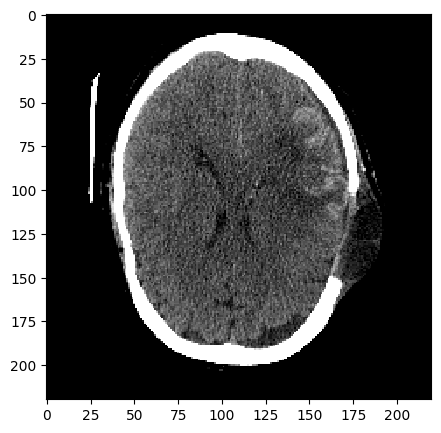

In [19]:
# img_ref = img[:, [img.shape[1]//2], ...]
img_ref = np.copy(img[:, 30:33,:,:])
print(img_ref.shape)
plt.figure(figsize=[5,5])
plt.imshow(back_to_HU(img_ref[0, 0]), 'gray', vmin=0, vmax=100)

In [37]:
projector = ct_projector.ct_projector()
projector.from_file('projector_fan.cfg')
projector.nv = 1
projector.nz = 1
projector.ny = img_ref.shape[2]
projector.nx = img_ref.shape[3]
projector.du = projector.du * projector.dso / projector.dsd

projector.dx = spacing[2]
projector.dy = spacing[1]
projector.dz = spacing[0]

projector.nview = 1400
# for k in vars(projector):
#     print (k, '=', getattr(projector, k))

angles = ff.get_angles_zc(1400, 360,0)

In [38]:
origin_img = img_ref[0,...]
origin_img = origin_img[:,np.newaxis,...]
print(origin_img.shape)

(3, 1, 220, 220)


In [39]:
cp.cuda.Device(device).use()

curef = cp.array(origin_img, order='C')
cuangles = cp.array(angles, order='C')

projector.set_projector(ct_fan.distance_driven_fp, angles=cuangles, branchless = False)
projector.set_backprojector(ct_fan.distance_driven_bp, angles=cuangles, is_fbp = True)

projection shape:  (3, 1400, 1, 736)


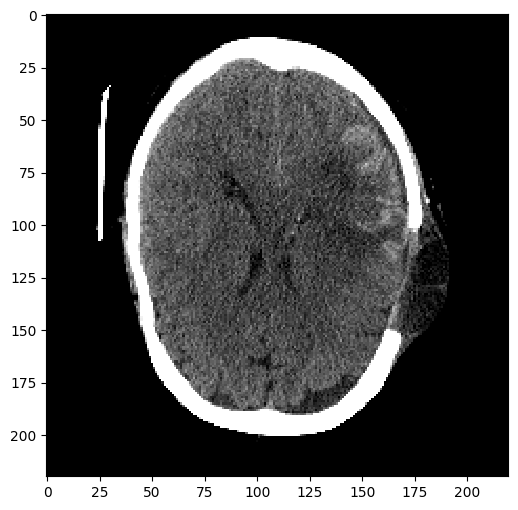

In [40]:
# FP
cuprj = projector.fp(curef, angles=cuangles)
prj = cuprj.get()
print('projection shape: ',prj.shape)

# FBP
fprj = numpy_fan.ramp_filter(projector, prj, filter_type = 'rl')
cufprj = cp.array(fprj, cp.float32, order = 'C')
fbp = projector.bp(cufprj)
fbp = fbp.get()
# fbp = ct_para_numpy.distance_driven_bp(projector, fprj, angles, True)

plt.figure(figsize=[6,6])
plt.imshow(back_to_HU(fbp[0, 0]), 'gray',vmin=0, vmax=100)

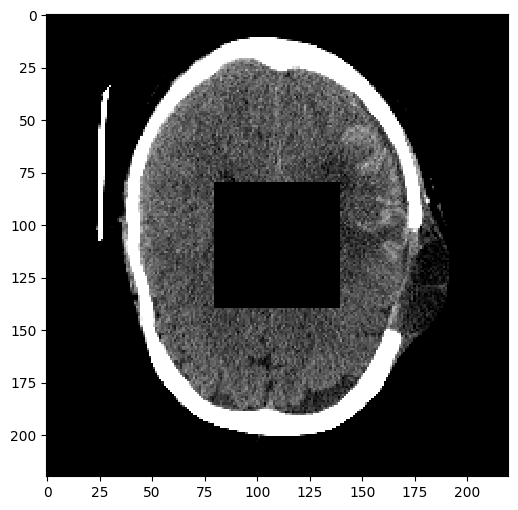

In [27]:
# add some errors to FBP
fbp_disturb = np.copy(fbp)
fbp_disturb[..., 80:140, 80:140] = 0
plt.figure(figsize=[6,6])
plt.imshow(back_to_HU(fbp_disturb[0, 0]), 'gray',vmin=0, vmax=100)

In [36]:
# TV reconstruction
niter = 50
nos = 12  ######## what's os and nos?
nesterov = 0.5
beta = 0.001
zero_init = False

projector_norm = projector.calc_projector_norm()
cunorm_img = projector.calc_norm_img() / projector_norm / projector_norm
print('norm img shape: ',cunorm_img.shape)

# cufbp = cp.array(fbp, order='C')
cufbp = cp.array(fbp_disturb, order='C')

if zero_init:
    curecon = cp.zeros(cufbp.shape, cp.float32)
    cunesterov = cp.zeros(cufbp.shape, cp.float32)
else:    
    curecon = cp.copy(cufbp)
    cunesterov = cp.copy(curecon)

for i in range(niter):
    for os in range(nos):
        inds = np.arange(os, len(cuangles), nos)   ##### pick a projection view every nos view and do this in an incremental way?
        cuangles_current = cp.copy(cuangles[inds], 'C')
        cuprj_current = cp.copy(cuprj[:, inds, ...], 'C')

        curecon, cunesterov = ct_recon.nesterov_acceleration(
            ct_recon.sqs_gaussian_one_step,
            img=curecon,
            img_nesterov=cunesterov,
            recon_kwargs={
                'projector': projector,
                'prj': cuprj,
                'norm_img': cunorm_img,
                'projector_norm': projector_norm,
                'beta': beta
            }
        )

    if (i + 1) % 10 == 0:
        _, data_loss, prior_loss = ct_recon.sqs_gaussian_one_step(
            projector,
            curecon,
            cuprj,
            cunorm_img,
            projector_norm,
            beta,
            return_loss=True
        )

        print(i + 1, data_loss, prior_loss)

0,1,2,3,4,5,6,7,8,9,
norm img shape:  (1, 1, 220, 220)


KeyboardInterrupt: 

recon shape:  (3, 1, 220, 220)


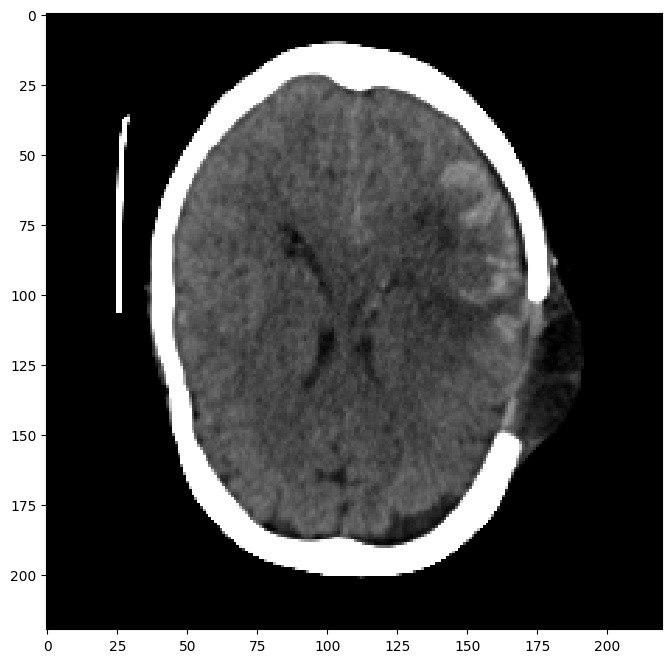

In [29]:
recon = curecon.get()
print('recon shape: ', recon.shape)
plt.figure(figsize=[8, 8])
plt.imshow(back_to_HU(recon[0, 0]), 'gray', vmin=0, vmax=100)

20.535713


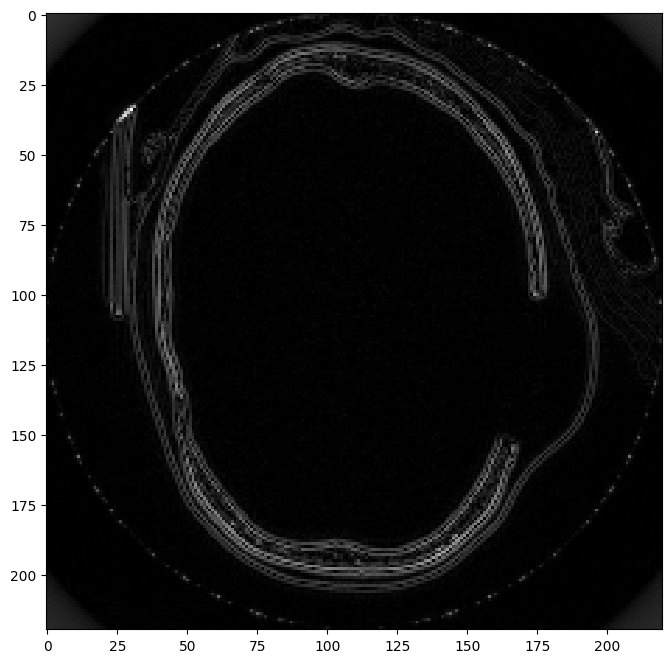

In [30]:
delta = np.abs(back_to_HU(recon) - back_to_HU(fbp))
print(np.mean(delta))

plt.figure(figsize=[8, 8])
plt.imshow(delta[0, 0], 'gray')